# Satisfacción de clientes

In [44]:
import warnings
warnings.filterwarnings('ignore')

import os
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import ADASYN

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [62]:
dfSatisfaccionTrain = pd.read_csv("train.csv")
dfSatisfaccionTest = pd.read_csv('test.csv')

# 1. EDA

In [49]:
dfSatisfaccionTrain.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [50]:
dfSatisfaccionTrain.shape

(76020, 371)

In [51]:
numCat = dfSatisfaccionTrain.select_dtypes(include=['object', 'category', 'bool']).shape[1]
numNum = dfSatisfaccionTrain.select_dtypes(include=['number']).shape[1]

print(f"Columnas numéricas: {numNum}")
print(f"Columnas categóricas: {numCat}")

Columnas numéricas: 371
Columnas categóricas: 0


In [52]:
dfSatisfaccionTrain['TARGET'].value_counts()

TARGET
0    73012
1     3008
Name: count, dtype: int64

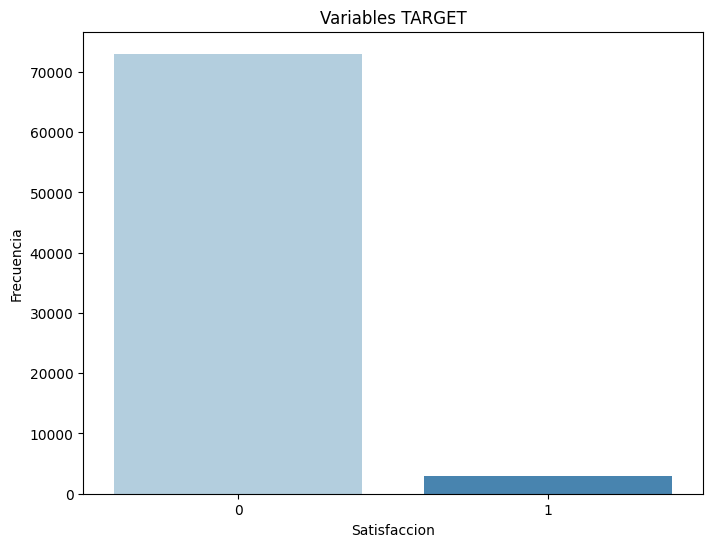

In [66]:
plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=dfSatisfaccionTrain, palette='Blues')
plt.title("Variables TARGET")
plt.xlabel("Satisfaccion")
plt.ylabel("Frecuencia")
plt.show()

tenemos el dataset de la satisfaccion de los clientes con `76020` registros las cuales tienen `371` columnas de variables, todas numericas incluyendo al final la columna `TARGET` la cual tiene los valores `[0, 1]` y es la que usaremos para las predicciones de satisfacción 

## 1.1. analisis estadistico y valores faltantes

In [54]:
dfSatisfaccionTrain.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [55]:
sdt = dfSatisfaccionTrain.describe().iloc[2].sort_values(ascending=False)
sdt.head()

delta_num_aport_var13_1y3     6.959537e+08
delta_imp_aport_var13_1y3     6.959537e+08
delta_imp_compra_var44_1y3    3.033108e+08
delta_num_compra_var44_1y3    3.033108e+08
delta_imp_venta_var44_1y3     2.349869e+08
Name: std, dtype: float64

se puede observar como lo que mas sobresale es una desviación estandar en algunas variables los cuales se pueden relacionar con los cuartiles se observa que son ceros

In [56]:
faltantes = dfSatisfaccionTrain.isnull().sum().sort_values(ascending = False)
porcentajeFaltantes = faltantes / dfSatisfaccionTrain.shape[0]

dfFaltantes = pd.DataFrame({
    'Num Faltantes': faltantes,
    'Porcentaje': porcentajeFaltantes
}).reset_index()

print(f"valores unicos faltantes: {faltantes.unique()}")
print(f"valores unicos porcentajeFaltantes: {porcentajeFaltantes.unique()}")

dfFaltantes

valores unicos faltantes: [0]
valores unicos porcentajeFaltantes: [0.]


,index,Num Faltantes,Porcentaje
0,ID,0,0.0
1,imp_trasp_var17_in_ult1,0,0.0
2,ind_var7_emit_ult1,0,0.0
3,imp_venta_var44_ult1,0,0.0
4,imp_venta_var44_hace3,0,0.0
...,...,...,...
366,num_op_var40_hace3,0,0.0
367,num_op_var40_hace2,0,0.0
368,num_var25,0,0.0
369,num_var25_0,0,0.0


se puede observar que no hay datos faltantes en todas las columnas tanto de las variables como el `TARGET`

## 1.2. Analisis de las variables

In [63]:
analisisVariables = dfSatisfaccionTrain.drop(columns=["ID","TARGET"]).copy()

para esto descartamos las columnas `ID` y `TARGET` ya que no hace falta para el anaisis de variables

In [64]:
solofloat = analisisVariables.select_dtypes(include=['float64'])
num = 20
variablesrandom = solofloat.sample(n=num, axis=1, random_state=8)

## 1.3. analisis de graficas

In [31]:
variablesrandom.describe()

,saldo_var33,saldo_medio_var29_ult1,imp_compra_var44_hace3,imp_aport_var17_ult1,saldo_var26,imp_op_var39_comer_ult1,saldo_medio_var12_hace2,imp_trasp_var33_in_ult1,saldo_medio_var17_hace2,saldo_var1,saldo_var25,saldo_medio_var29_hace3,imp_op_var41_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var17_ult1,imp_ent_var16_ult1,saldo_var31,saldo_medio_var8_hace3,delta_imp_aport_var13_1y3,saldo_medio_var5_hace2
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,76020.000000,7.602000e+04,76020.000000
mean,12.532333,0.253907,13.964581,31.105323,76.081633,72.363067,3.997023e+03,0.314701,9.117181e+01,4.844911e+01,72.735693,0.001910,137.242763,3857.848542,1.310316e+02,86.208265,2.922910e+02,9.505287,4.867140e+07,1579.135311
std,797.839557,52.078775,1151.510862,2457.091282,739.776626,339.315831,3.777314e+04,53.408085,1.539248e+04,1.093747e+04,726.882669,0.526626,697.712596,25572.245055,1.495653e+04,1614.757313,2.331640e+04,519.389157,6.959537e+08,12148.452398
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-3.000000e-02,-9.000000e-01,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,-1.000000e+00,-128.370000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,3.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,90.000000
max,142078.800000,13793.670000,210001.350000,432457.320000,69756.720000,12888.030000,3.000538e+06,13207.320000,4.210084e+06,3.000000e+06,69756.720000,145.200000,47598.090000,450000.000000,3.998687e+06,210000.000000,6.119500e+06,77586.210000,1.000000e+10,812137.260000


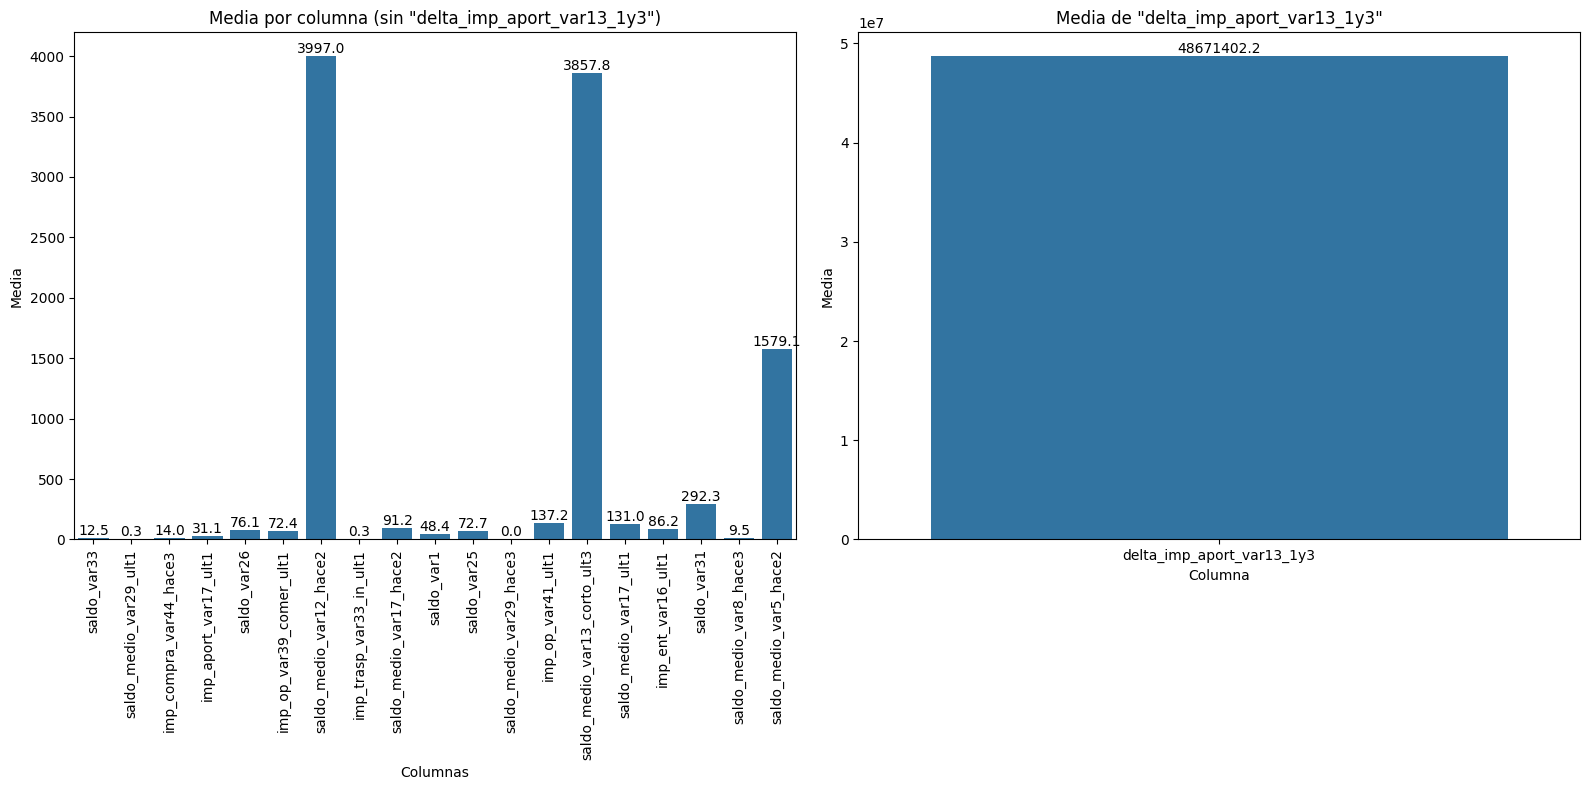

In [46]:
mean_values = variablesrandom.mean()

std_values_main = mean_values.drop('delta_imp_aport_var13_1y3')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(x=std_values_main.index, y=std_values_main.values, ax=ax1)
ax1.set_title('Media por columna (sin "delta_imp_aport_var13_1y3")')
ax1.set_xlabel('Columnas')
ax1.set_ylabel('Media')
ax1.tick_params(axis='x', rotation=90)

for i, v in enumerate(std_values_main.values):
    ax1.text(i, v + 0.01, f'{v:.1f}', ha='center', va='bottom')

sns.barplot(x=['delta_imp_aport_var13_1y3'], y=[mean_values['delta_imp_aport_var13_1y3']], ax=ax2)
ax2.set_title('Media de "delta_imp_aport_var13_1y3"')
ax2.set_xlabel('Columna')
ax2.set_ylabel('Media')

ax2.text(0, mean_values['delta_imp_aport_var13_1y3'] + 0.01, f'{mean_values["delta_imp_aport_var13_1y3"]:.1f}', 
         ha='center', va='bottom')

plt.tight_layout()
plt.show()

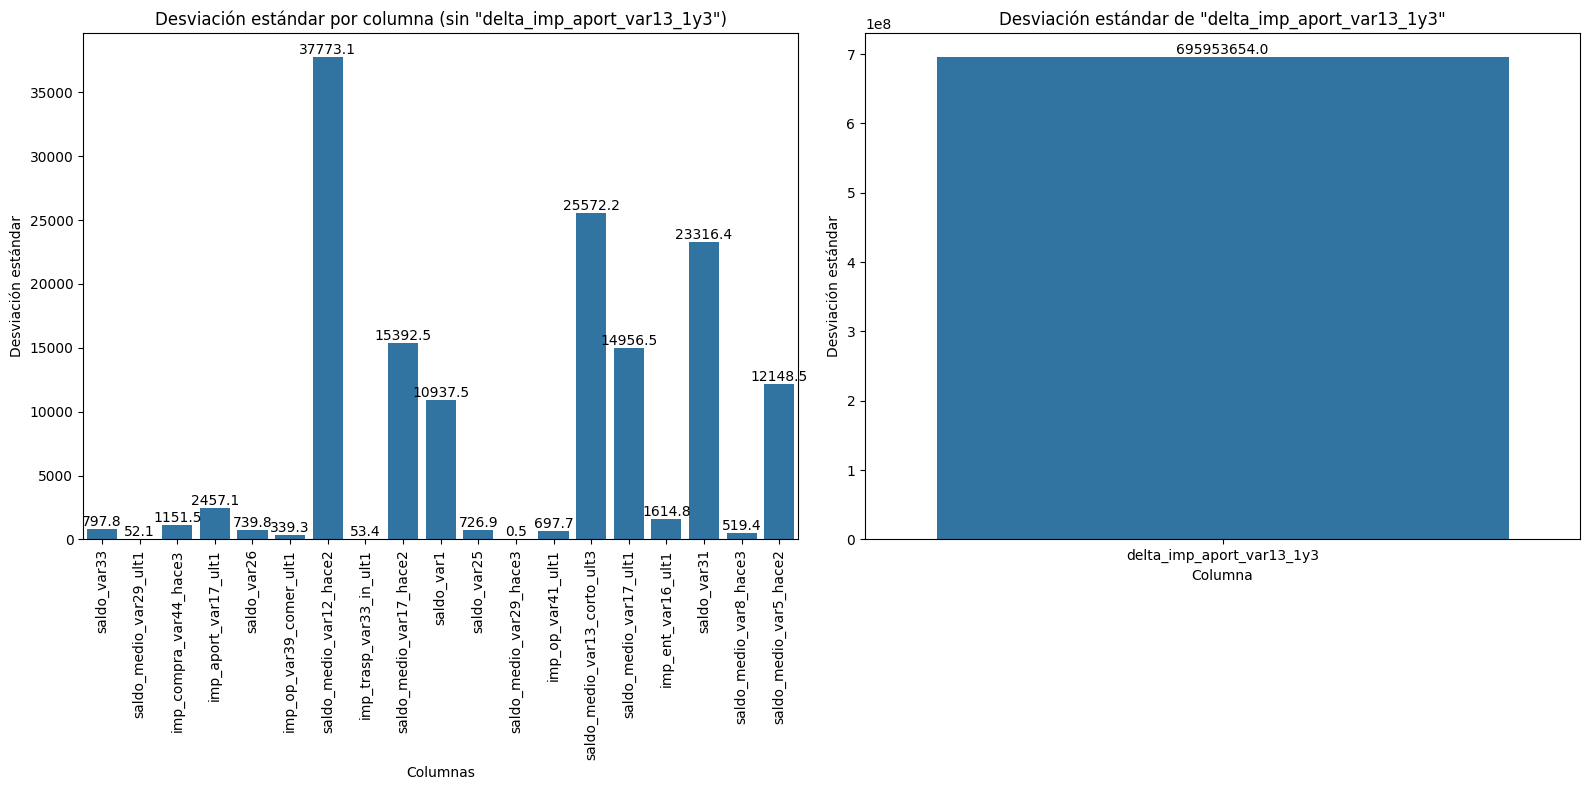

In [47]:
std_values = variablesrandom.std()

std_values_main = std_values.drop('delta_imp_aport_var13_1y3')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(x=std_values_main.index, y=std_values_main.values, ax=ax1)
ax1.set_title('Desviación estándar por columna (sin "delta_imp_aport_var13_1y3")')
ax1.set_xlabel('Columnas')
ax1.set_ylabel('Desviación estándar')
ax1.tick_params(axis='x', rotation=90)

for i, v in enumerate(std_values_main.values):
    ax1.text(i, v + 0.01, f'{v:.1f}', ha='center', va='bottom')

sns.barplot(x=['delta_imp_aport_var13_1y3'], y=[std_values['delta_imp_aport_var13_1y3']], ax=ax2)
ax2.set_title('Desviación estándar de "delta_imp_aport_var13_1y3"')
ax2.set_xlabel('Columna')
ax2.set_ylabel('Desviación estándar')

ax2.text(0, std_values['delta_imp_aport_var13_1y3'] + 0.01, f'{std_values["delta_imp_aport_var13_1y3"]:.1f}', 
         ha='center', va='bottom')

plt.tight_layout()
plt.show()

en estos graficas podemos ver visualmente las desviaciones estandar y las medias de las variables seleccionadas la cuales podemos observar que en los dos casos tanto `mean` como `std` varian una con respecto del otro y teniendo que colocar la variable `delta_imp_aport_var13_1y3` en una grafica aparte del resto por temas de escala ya que supera por varios ordenes de magnitud a demás

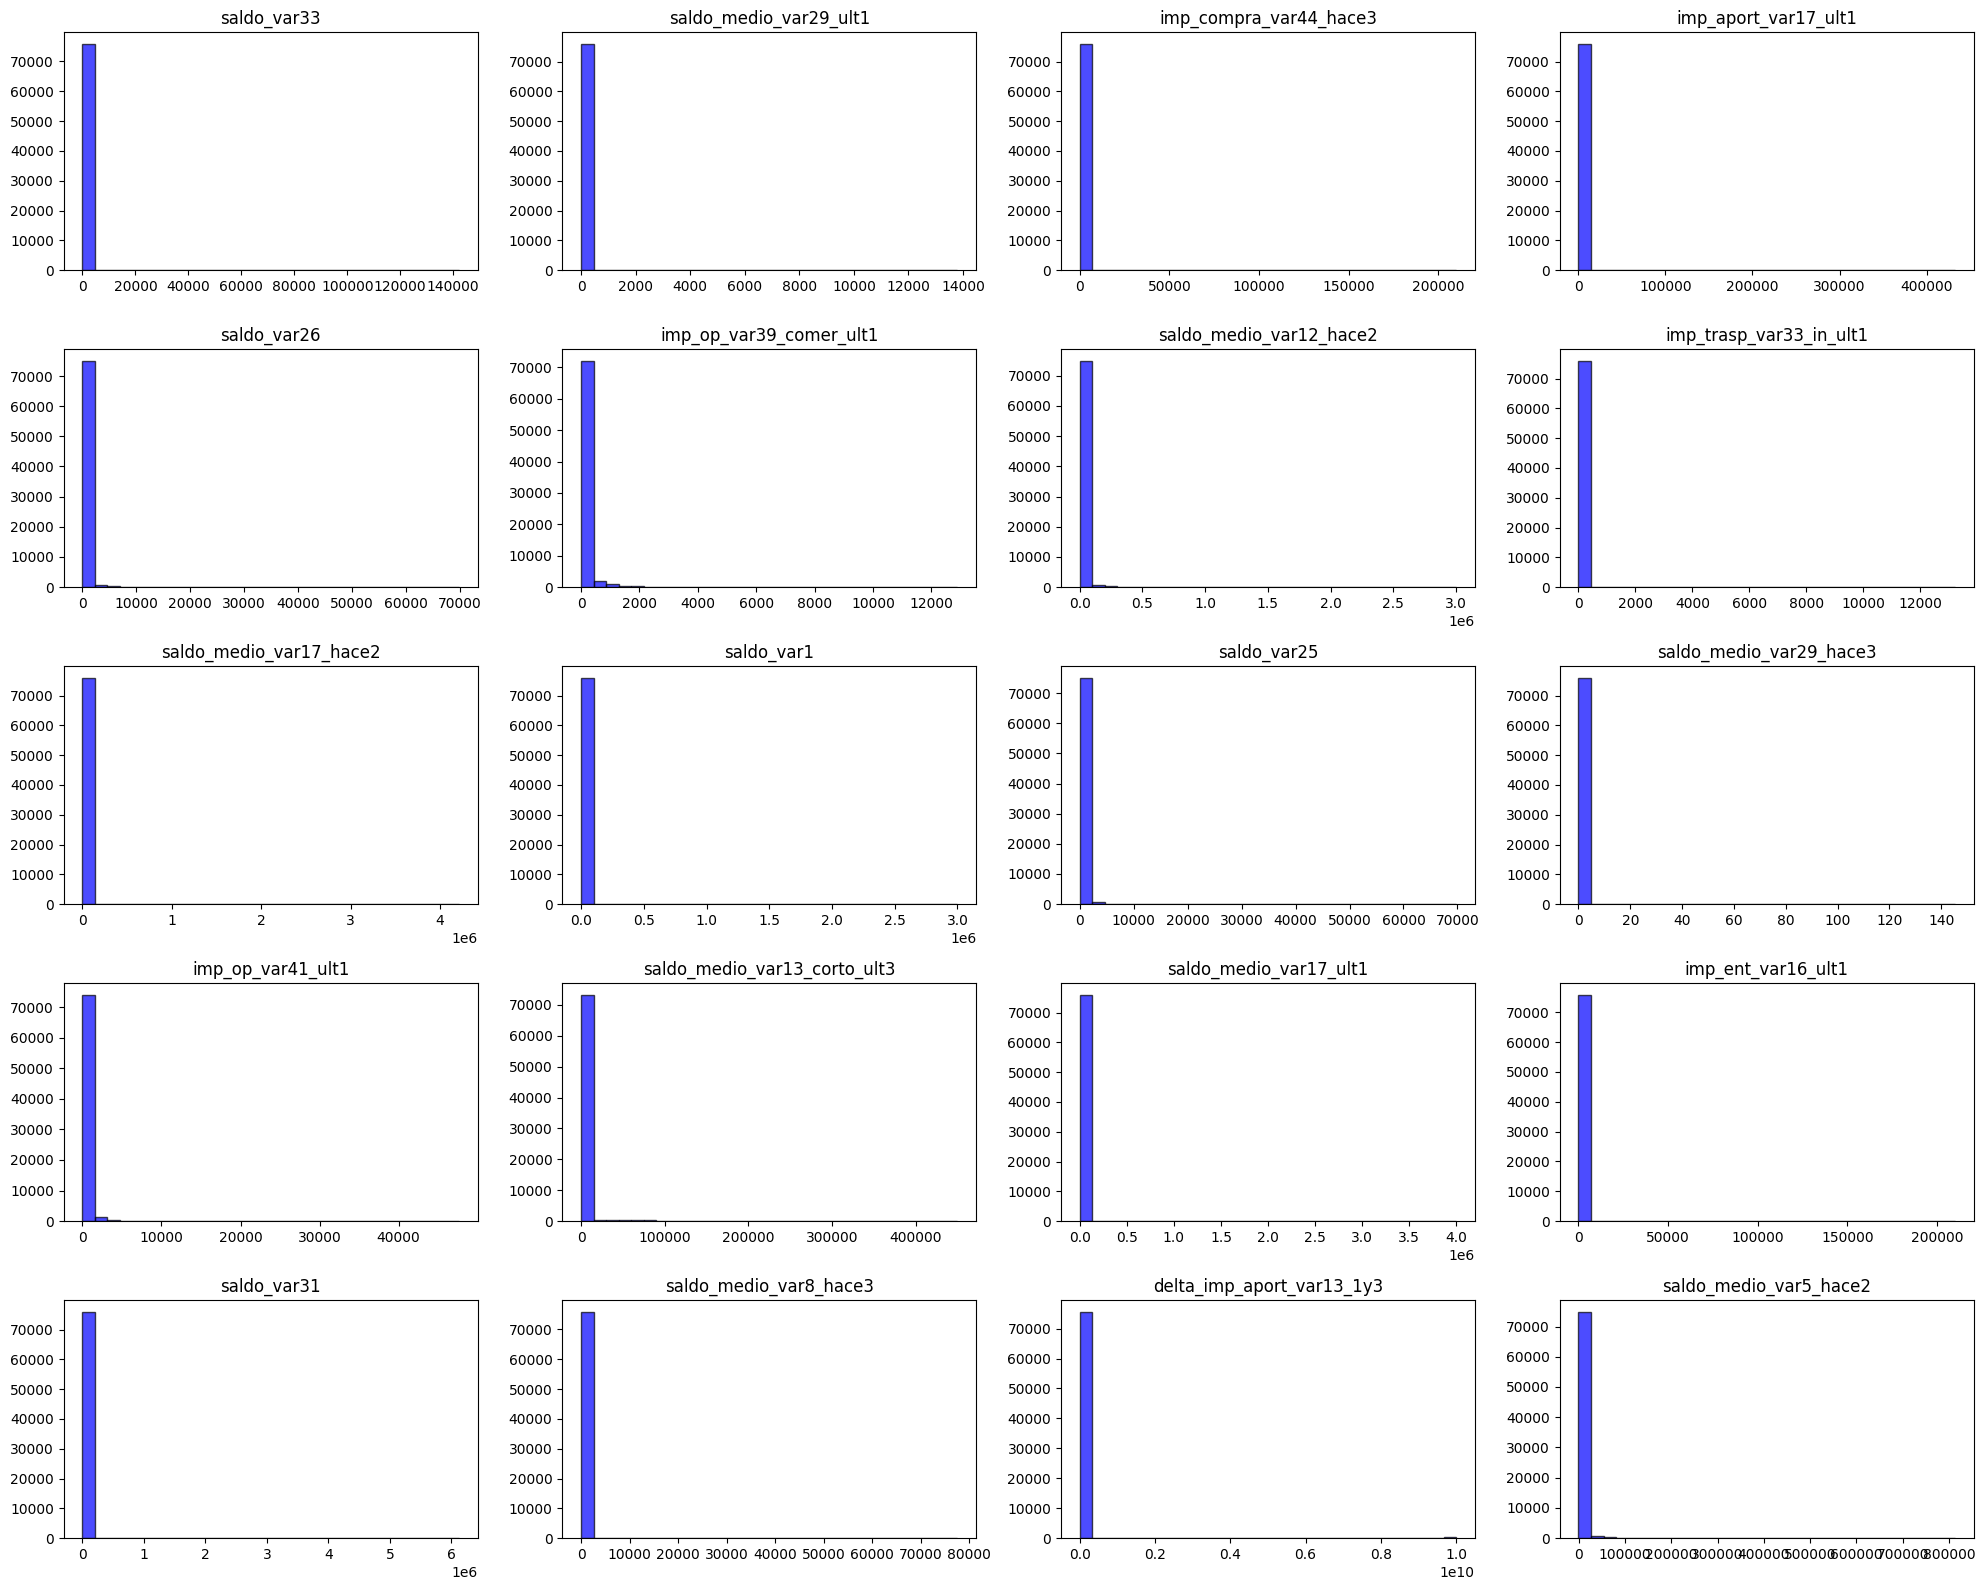

In [70]:

# Suponiendo que `variablesrandom` es tu DataFrame
cols = variablesrandom.columns
plt.figure(figsize=(20, 16))

for i, var in enumerate(cols, 1):
    plt.subplot(5, 4, i)
    # Histograma con matplotlib
    plt.hist(variablesrandom[var].dropna(), bins=30, color='blue', alpha=0.7, edgecolor='black')
    plt.title(var)
    plt.xlabel('')  # Opcional: dejar vacío
    plt.ylabel('')  # Opcional: dejar vacío

plt.tight_layout()
plt.show()


en las graficas anteriores vemos las distribuciones de las 20 variables seleccionadas y estas parecen tender a parecerse con la mayoria de los valores cercanos a cero sin mostar indicios claros de alguna distribucion 

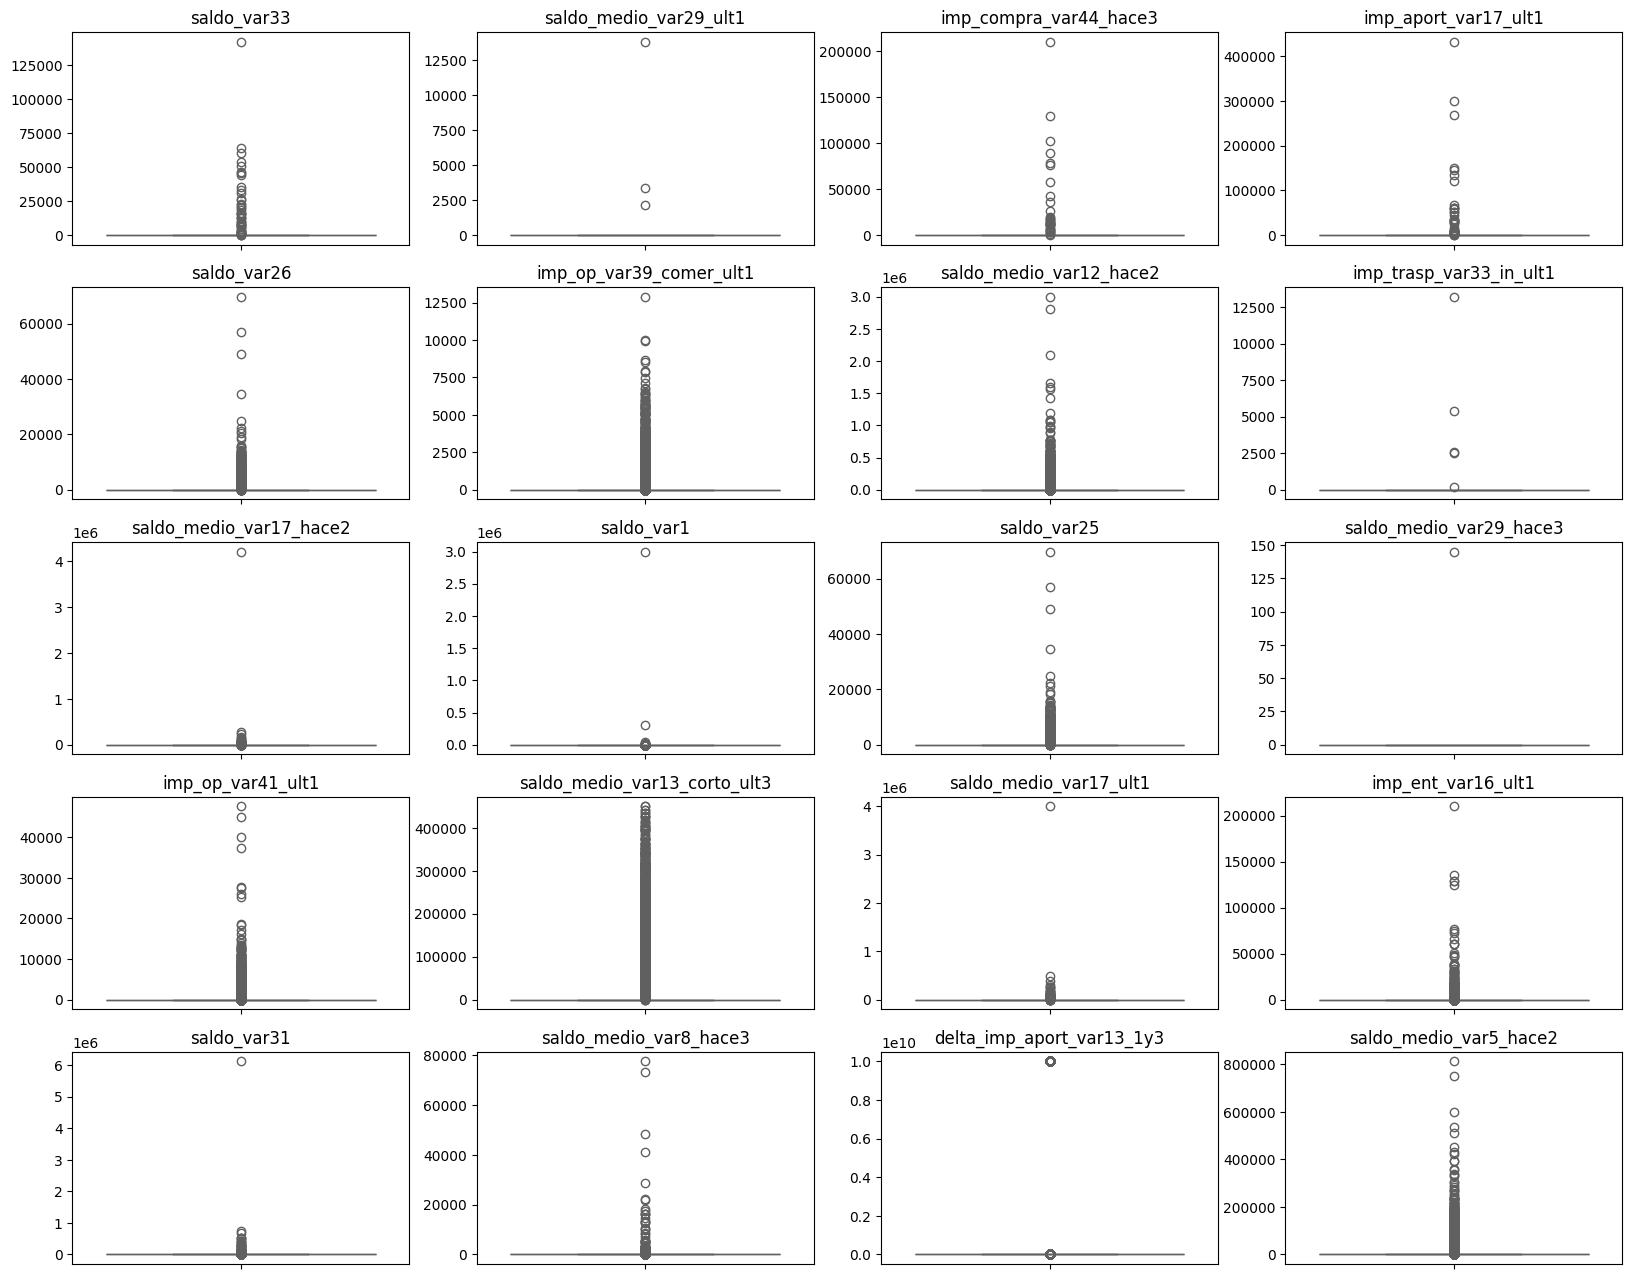

In [6]:
plt.figure(figsize=(20, 16))
for i, var in enumerate(cols, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(variablesrandom[var], palette='Blues', legend=False)
    plt.title(var)
    plt.xlabel('')
    plt.ylabel('')

plt.show()

Observando los diagramas nuevamente observamos como las cajas no se logran ver a simple vista y que las apuntan cercano a un valor dandose ver que la mayoria de las graficas presentan datos atípicos 

## 1.4. Analisis bivariado y reduccion de dimensionalidad

In [ ]:
matrizCorrelacion = analisisVariables.corr()
matrizCorrelacion

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
var3,1.000000,-0.004452,0.001868,0.005989,0.006817,0.001518,0.001690,0.000530,0.000611,0.001311,...,0.000229,0.000716,0.000491,0.000638,0.000669,0.000617,0.000508,0.000738,0.000778,0.000071
var15,-0.004452,1.000000,0.043722,0.094762,0.101177,0.042754,0.048512,0.008805,0.009678,0.035884,...,0.011623,0.029358,0.017264,0.028504,0.029176,0.029180,0.018884,0.032833,0.033597,0.006497
imp_ent_var16_ult1,0.001868,0.043722,1.000000,0.041221,0.034879,0.009896,0.009377,0.000592,0.002510,0.011502,...,0.007428,-0.000864,-0.000632,-0.000548,-0.000540,0.002655,-0.000612,0.005055,0.006590,0.000007
imp_op_var39_comer_ult1,0.005989,0.094762,0.041221,1.000000,0.886476,0.342709,0.295295,0.032280,0.054809,0.249247,...,0.001123,0.016422,0.011719,0.012570,0.013703,0.009445,0.005532,0.011665,0.010802,0.012546
imp_op_var39_comer_ult3,0.006817,0.101177,0.034879,0.886476,1.000000,0.316671,0.355670,0.029094,0.055449,0.247707,...,0.000192,0.027489,0.021819,0.018427,0.020530,0.008539,0.006359,0.010660,0.009822,0.013271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
saldo_medio_var44_hace2,0.000617,0.029180,0.002655,0.009445,0.008539,-0.000436,-0.000561,-0.000211,-0.000243,-0.000393,...,0.003708,0.001174,-0.000187,0.003271,0.002914,1.000000,0.332172,0.818300,0.710593,0.002889
saldo_medio_var44_hace3,0.000508,0.018884,-0.000612,0.005532,0.006359,-0.000480,-0.000529,-0.000170,-0.000195,-0.000417,...,-0.000074,-0.000219,-0.000151,-0.000196,-0.000205,0.332172,1.000000,0.229158,0.213191,0.003646
saldo_medio_var44_ult1,0.000738,0.032833,0.005055,0.011665,0.010660,-0.000254,-0.000510,-0.000254,-0.000292,-0.000260,...,0.010993,0.000819,-0.000225,0.002493,0.002205,0.818300,0.229158,1.000000,0.968167,0.003258
saldo_medio_var44_ult3,0.000778,0.033597,0.006590,0.010802,0.009822,-0.000372,-0.000601,-0.000268,-0.000308,-0.000356,...,0.009088,0.000977,-0.000238,0.002905,0.002574,0.710593,0.213191,0.968167,1.000000,0.003037


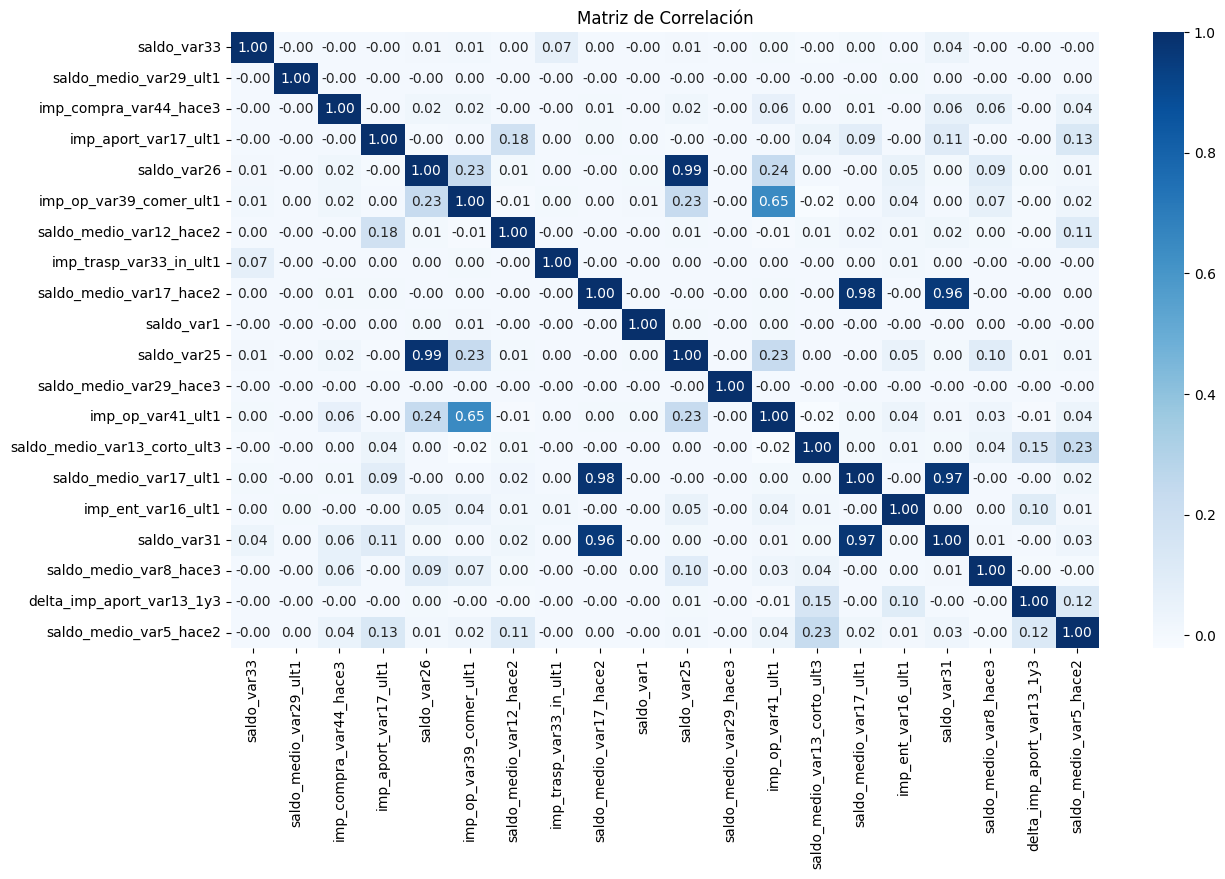

In [ ]:
matrizCorrelacionSelecs = variablesrandom.corr()

plt.figure(figsize=(14, 8))
sns.heatmap(matrizCorrelacionSelecs, annot=True, cmap='Blues', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

de las 20 variables aleatorias elegidas podemos ver que en algunas si existen varias variables que pueden relacionarse y tenemos que tomar acciones

Para manejar la alta colinealidad entre las columnas, utilizaremos la matriz de correlación para identificar y eliminar variables altamente correlacionadas, estableciendo una tolerancia del `80%`. Este enfoque es más eficiente que calcular el `VIF`, ya que evita el alto costo computacional de ajustar múltiples variables, simplificando el modelo sin comprometer la calidad del análisis.

In [16]:
CorrMat = analisisVariables.corr().abs()

diagonalSup = CorrMat.where(np.triu(np.ones(CorrMat.shape), k=1).astype(bool))
threshold = 0.8
dropCols = [column for column in diagonalSup.columns if any(diagonalSup[column] > threshold)]
print(f"Columnas descartadas: {dropCols}")
dfResultante = analisisVariables.drop(columns = dropCols)
print(f"columnas guardadas: {dfResultante.shape[1]}")

Columnas descartadas: ['imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult3', 'imp_op_var41_comer_ult1', 'imp_op_var41_comer_ult3', 'imp_op_var41_efect_ult3', 'imp_op_var41_ult1', 'imp_op_var39_efect_ult1', 'imp_op_var39_efect_ult3', 'imp_op_var39_ult1', 'ind_var8_0', 'ind_var8', 'ind_var12', 'ind_var13_corto_0', 'ind_var13_corto', 'ind_var13_largo', 'ind_var13_medio', 'ind_var13', 'ind_var17', 'ind_var18', 'ind_var20', 'ind_var24_0', 'ind_var24', 'ind_var26_0', 'ind_var26_cte', 'ind_var26', 'ind_var25_0', 'ind_var25', 'ind_var29_0', 'ind_var29', 'ind_var30', 'ind_var31', 'ind_var32_0', 'ind_var32', 'ind_var33', 'ind_var34', 'ind_var37_0', 'ind_var37', 'ind_var40_0', 'ind_var40', 'ind_var41_0', 'ind_var39', 'ind_var44', 'num_var1_0', 'num_var1', 'num_var5_0', 'num_var5', 'num_var6_0', 'num_var6', 'num_var8_0', 'num_var8', 'num_var12_0', 'num_var12', 'num_var13_0', 'num_var13_corto_0', 'num_var13_corto', 'num_var13_largo_0', 'num_var13_largo', 'num_var13_medio_

despues de realizar el proceso de reduccion de dimensionalidad reducimos el tamaño del dataset casi a la mitad (`55,01%`) pasando de `369` (excluyendo `ID` y `TARGET`) a `166` columnas lo cual ayudará a reducir el coste significativamente

In [49]:
dfResultante['TARGET'] = dfSatisfaccionTrain['TARGET']
dfResultante.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var40_comer_ult1,imp_op_var40_efect_ult1,imp_op_var40_ult1,imp_op_var41_efect_ult1,imp_sal_var16_ult1,ind_var1_0,...,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_medio_hace3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,var38,TARGET
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,2,37,0.0,195.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


procedemos a descartar las columnas del dataframe de test para tenerlo con las mismas columnas

In [50]:
dfResultanteTest = dfSatisfaccionTest.drop(columns=dropCols).drop(columns='ID')
dfResultanteTest.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var40_comer_ult1,imp_op_var40_efect_ult1,imp_op_var40_ult1,imp_op_var41_efect_ult1,imp_sal_var16_ult1,ind_var1_0,...,saldo_medio_var13_corto_hace3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_medio_hace3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,var38
0,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,40532.10
1,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,45486.72
2,2,23,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,46993.95
3,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,187898.61
4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,73649.73


confirmamos que los datasets de `train` y `test` tienen las mismas variables siendo `TARGET` la que está de más en el de `train` y procedemos a guardarlos en un nuevo archivo `CSV`

In [51]:
dfResultante.to_csv('TrainFormateado.csv', index=False)
dfResultanteTest.to_csv('TestFormateado.csv', index=False)

# 2. Modelos de clasificación 

In [3]:
TrainFormateado = pd.read_csv("TrainFormateado.csv")

In [13]:
dfTablaResultados = pd.DataFrame(columns=['Modelo' ,'precission' ,'recall' ,'accuracy' ,'f1-score' ,'AUC'])

## 2.1. separacion de TRAIN y TEST

In [14]:
TrainFormateado.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var40_comer_ult1,imp_op_var40_efect_ult1,imp_op_var40_ult1,imp_op_var41_efect_ult1,imp_sal_var16_ult1,ind_var1_0,...,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_medio_hace3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,var38,TARGET
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,2,37,0.0,195.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


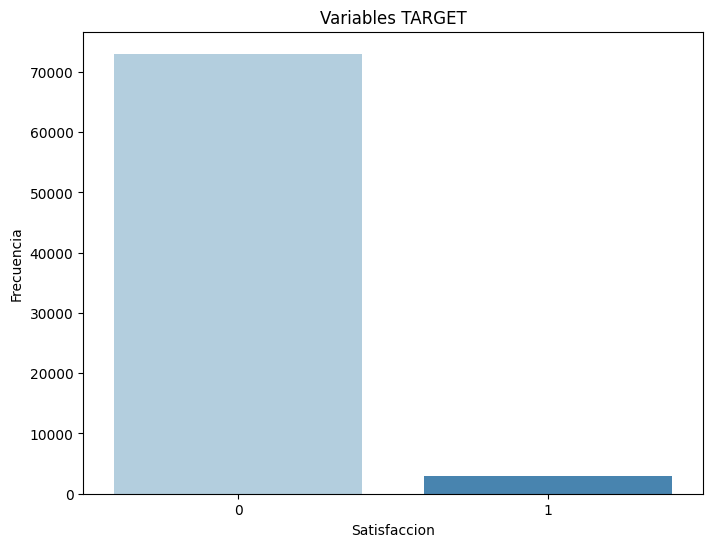

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=TrainFormateado, palette='Blues')
plt.title("Variables TARGET")
plt.xlabel("Satisfaccion")
plt.ylabel("Frecuencia")
plt.show()

tenemos las clases desvalanceadas lo cual usaremos `ADASYN` para que se ajuste automaticamente y balancee el cojunto de test generando datos simulados

In [16]:
X = TrainFormateado.drop(columns=['TARGET'])
y = TrainFormateado['TARGET']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [18]:
adasyn_train = ADASYN(random_state = 10)
adasyn_test = ADASYN(random_state = 45)
X_train_res, y_train_res = adasyn_train.fit_resample(X_train, y_train)
X_test_res, y_test_res = adasyn_test.fit_resample(X_test,y_test)

## 2.2. Clasificación Bayesiana

In [19]:
bayes_pipeline = Pipeline([('scaler', StandardScaler()), ('bayes', GaussianNB())])
bayes_paramgrid = {'bayes__var_smoothing': [10**1, 10**2, 10**3, 10**4 ]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

bayes_gridsearch = GridSearchCV(bayes_pipeline, bayes_paramgrid, cv=skf, scoring='roc_auc', n_jobs=-1)
bayes_gridsearch.fit(X_train_res, y_train_res)

print("Mejor score train:", bayes_gridsearch.best_score_)
print("Mejor parámetro:", bayes_gridsearch.best_params_)

pedict_baye = bayes_gridsearch.predict(X_test_res)
predProb_baye = bayes_gridsearch.best_estimator_.predict_proba(X_test_res)[:, 1]

#añade registro tabla
dfTablaResultados.loc[len(dfTablaResultados)] ={
    'Modelo': 'Clasificación Bayesiana',
    'precission': precision_score(y_test_res, pedict_baye),
    'recall': recall_score(y_test_res, pedict_baye),
    'accuracy': accuracy_score(y_test_res, pedict_baye),
    'f1-score': f1_score(y_test_res, pedict_baye),
    'AUC': roc_auc_score(y_test_res, predProb_baye),
}

Mejor score train: 0.8003051410457687
Mejor parámetro: {'bayes__var_smoothing': 1000}


## 2.3. KNN

In [ ]:
knn_pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_paramgrid = {'knn__n_neighbors': list(range(6, 11)),  'knn__p': [1]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

knn_gridsearch = GridSearchCV(knn_pipeline, knn_paramgrid, cv=skf, scoring='roc_auc', n_jobs=-1)
knn_gridsearch.fit(X_train_res, y_train_res)

print("Mejor score de entrenamiento:", knn_gridsearch.best_score_)
print("Mejor parámetro:", knn_gridsearch.best_params_)

pedict_knn = knn_gridsearch.predict(X_test_res)
predProb_knn = knn_gridsearch.best_estimator_.predict_proba(X_test_res)[:, 1]

#añade registro tabla
dfTablaResultados.loc[len(dfTablaResultados)] ={
    'Modelo': 'KNN',
    'precission': precision_score(y_test_res, pedict_knn),
    'recall': recall_score(y_test_res, pedict_knn),
    'accuracy': accuracy_score(y_test_res, pedict_knn),
    'f1-score': f1_score(y_test_res, pedict_knn),
    'AUC': roc_auc_score(y_test_res, predProb_knn),
}

In [76]:
print("Mejor score de entrenamiento:", knn_gridsearch.best_score_)
print("Mejor parámetro:", knn_gridsearch.best_params_)

Mejor score de entrenamiento: 0.9435836440931732
Mejor parámetro: {'knn__n_neighbors': 10, 'knn__p': 1}


## 2.4. L1/L2 Penalty Logistic Regression

In [ ]:
lr_pipeline = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(solver='saga', max_iter=50, random_state=18))])
lr_paramgrid = {'lr__penalty': ['l1', 'l2'], 'lr__C': [10**-1, 1, 10**2, 10**3, 10**4]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

lr_gridsearch = GridSearchCV(estimator=lr_pipeline, param_grid=lr_paramgrid, scoring='roc_auc', cv=skf, n_jobs=-1)
lr_gridsearch.fit(X_train_res, y_train_res)

print("Mejor score de entrenamiento:", lr_gridsearch.best_score_)
print("Mejores parámetros:", lr_gridsearch.best_params_)

pedict_logr = lr_gridsearch.predict(X_test_res)
predProb_logr = lr_gridsearch.best_estimator_.predict_proba(X_test_res)[:, 1]

#añade registro tabla
dfTablaResultados.loc[len(dfTablaResultados)] ={
    'Modelo': 'L1/L2 Penalty Logistic Regression',
    'precission': precision_score(y_test_res, pedict_logr),
    'recall': recall_score(y_test_res, pedict_logr),
    'accuracy': accuracy_score(y_test_res, pedict_logr),
    'f1-score': f1_score(y_test_res, pedict_logr),
    'AUC': roc_auc_score(y_test_res, predProb_logr),
}

Mejor score de entrenamiento: 0.8721222197184586
Mejores parámetros: {'lr__C': 1000, 'lr__penalty': 'l2'}


## 2.5. Random Forest

In [ ]:
rf_pipeline= Pipeline([('rf', RandomForestClassifier(random_state=18))])
rf_paramgrid = {'rf__n_estimators': [500, 550, 600], 'rf__max_depth': [30, 35, 45 ]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

rf_gridsearch = GridSearchCV(estimator=rf_pipeline, param_grid=rf_paramgrid,cv=skf, scoring='roc_auc', n_jobs=-1)
rf_gridsearch.fit(X_train_res, y_train_res)

print("Mejor score de entrenamiento:", rf_gridsearch.best_score_)
print("Mejor parámetro:", rf_gridsearch.best_params_)

pedict_randfo = rf_gridsearch.predict(X_test_res)
predProb_randfo = rf_gridsearch.best_estimator_.predict_proba(X_test_res)[:, 1]

#añade registro tabla
dfTablaResultados.loc[len(dfTablaResultados)] ={
    'Modelo': 'Random Forest',
    'precission': precision_score(y_test_res, pedict_randfo),
    'recall': recall_score(y_test_res, pedict_randfo),
    'accuracy': accuracy_score(y_test_res, pedict_randfo),
    'f1-score': f1_score(y_test_res, pedict_randfo),
    'AUC': roc_auc_score(y_test_res, predProb_randfo),
}



Mejor score de entrenamiento: 0.9850666070172002
Mejor parámetro: {'rf__max_depth': 35, 'rf__n_estimators': 550}


## 2.6. XGBoost

In [ ]:
xgb_pipeline = Pipeline([('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=18))])
xgb_paramgrid = {'xgb__max_depth': range(8, 12), 'xgb__n_estimators': [100, 150, 200], 'xgb__learning_rate': [0.1, 1, 10]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

xgb_gridsearch = GridSearchCV(xgb_pipeline, param_grid=xgb_paramgrid, cv=skf, scoring='roc_auc', n_jobs=-1)
xgb_gridsearch.fit(X_train_res, y_train_res)

print("Mejor score de entrenamiento:", xgb_gridsearch.best_score_)
print("Mejor parámetro:", xgb_gridsearch.best_params_)

pedict_xgb = xgb_gridsearch.predict(X_test_res)
predProb_xgb = xgb_gridsearch.best_estimator_.predict_proba(X_test_res)[:, 1]

#añade registro tabla
dfTablaResultados.loc[len(dfTablaResultados)] ={
    'Modelo': 'XGBoost',
    'precission': precision_score(y_test_res, pedict_xgb),
    'recall': recall_score(y_test_res, pedict_xgb),
    'accuracy': accuracy_score(y_test_res, pedict_xgb),
    'f1-score': f1_score(y_test_res, pedict_xgb),
    'AUC': roc_auc_score(y_test_res, predProb_xgb),
}

Mejor score de entrenamiento: 0.9845058535518112
Mejor parámetro: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 11, 'xgb__n_estimators': 200}


## 2.7. SVM

![img](assests/svmTimeout.png "svmTimeout")

para agilizar el entrenamiento de `SVM` en vez de recorrer los hiper parametros `C:[1, 10, 100]`, `kernel:[poly, rbf]`, `gamma:[scale, auto]` usaremos de una `C:10`, `gamma:scale`, `kernel:poly`

In [ ]:
svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC(probability=True, random_state=18))])

#svm_paramgrid = {'svm__C': [10], 'svm__kernel': ['poly'], 'svm__gamma': ['scale']}
svm_paramgrid = {}

print("gridsearch...")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
svm_gridsearch = GridSearchCV(estimator=svm_pipeline, param_grid=svm_paramgrid, scoring='roc_auc', cv=skf, n_jobs=-1)

print("fit...")

svm_gridsearch.fit(X_train_res, y_train_res)

print("Mejor score de entrenamiento:", svm_gridsearch.best_score_)
print("Mejor parámetro:", svm_gridsearch.best_params_)

print("predict 1...")

pedict_svm = svm_gridsearch.predict(X_test_res)

print("predict 2...")

predProb_svm = svm_gridsearch.best_estimator_.predict_proba(X_test_res)[:, 1]

#añade registro tabla
dfTablaResultados.loc[len(dfTablaResultados)] ={
    'Modelo': 'SVM',
    'precission': precision_score(y_test_res, pedict_svm),
    'recall': recall_score(y_test_res, pedict_svm),
    'accuracy': accuracy_score(y_test_res, pedict_svm),
    'f1-score': f1_score(y_test_res, pedict_svm),
    'AUC': roc_auc_score(y_test_res, predProb_svm),
}

## 2.8. Conclusiones modelos

In [41]:
dfTablaResultados

,Modelo,precission,recall,accuracy,f1-score,AUC
0,Clasificación Bayesiana,0.502779,1.000000,0.502982,0.669132,0.796743
1,KNN,0.889644,0.718956,0.813934,0.795244,0.894397
2,L1/L2 Penalty Logistic Regression,0.761319,0.834791,0.785439,0.796364,0.873012
3,Random Forest,0.924471,0.861648,0.895088,0.891955,0.955487
4,XGBoost,0.925861,0.893523,0.910529,0.909405,0.970093


teniendo en cuenta la metrica `AUC` concluimos que el modelo que major desempeño y mejor se ajustó fue el `XGBoost` con un valor de `0.97` y que su vez tambien fue mejor en las demás metricas exeptuando en `recall` ya que si bien no es la primera cuenta con un alto scrore

## 2.9. matrices de confusión

In [42]:
models = {
        "Clasificación Bayesiana": pedict_baye,
        "KNN": pedict_knn,
        "Regresión Logística": pedict_logr,
        "Random Forest": pedict_randfo,
        "XGBoost": pedict_xgb,
        #"SVM": pedict_svm
}

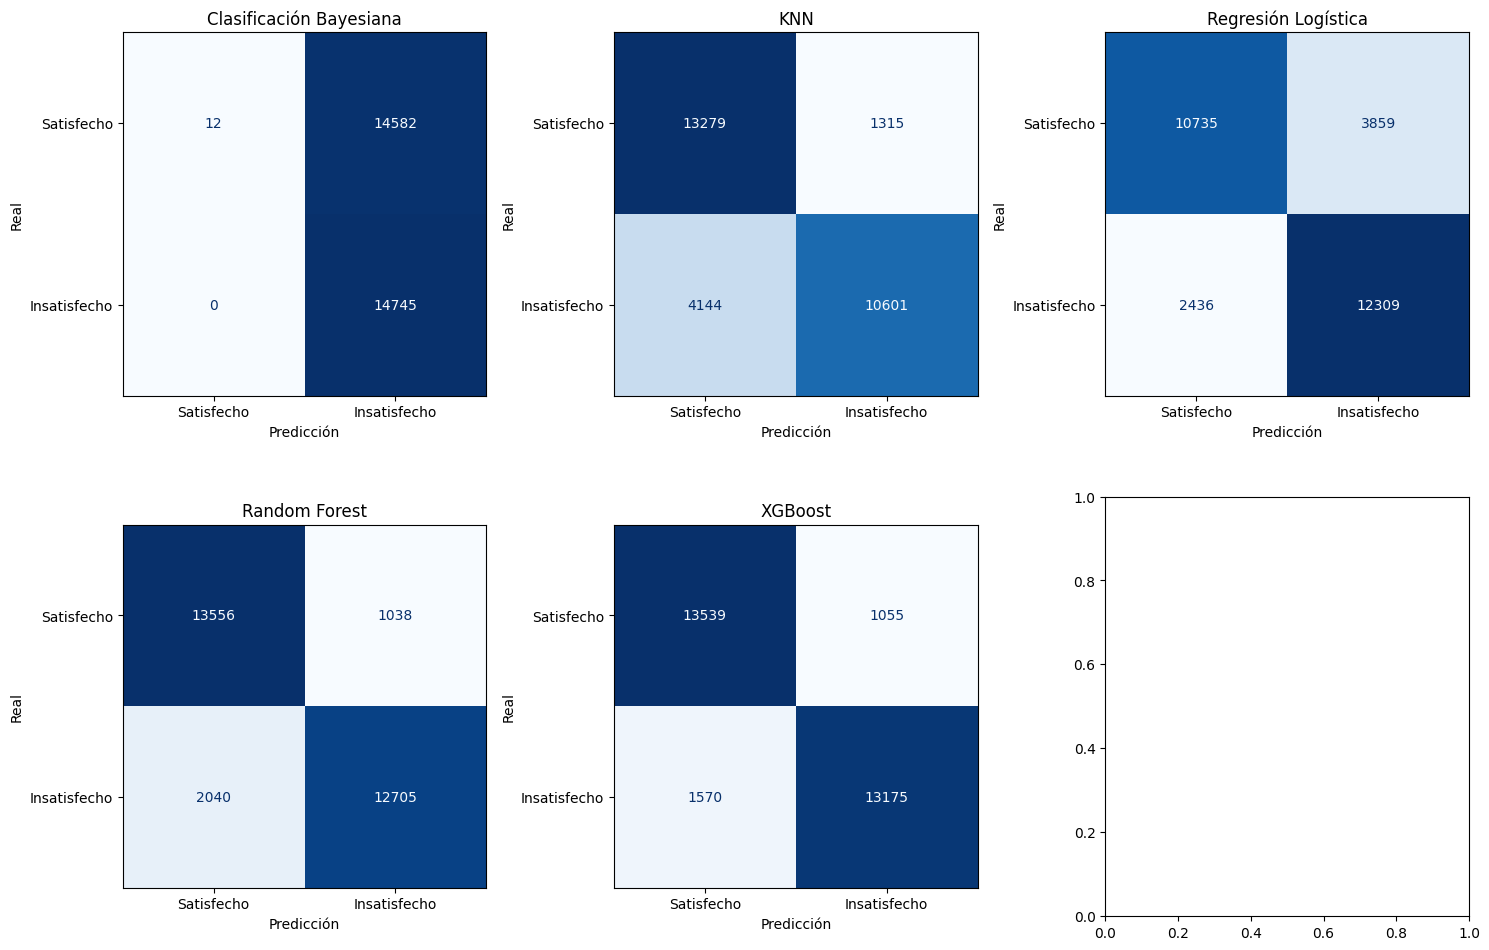

In [56]:
estado = ["Satisfecho", "Insatisfecho"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (name, predictions) in enumerate(models.items()):
    confMat = confusion_matrix(y_test_res, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=estado)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Real")

plt.tight_layout()
plt.show()

## 2.10. curvas ROC

In [46]:
modelsProb = {
        "Clasificación Bayesiana": predProb_baye,
        "KNN": predProb_knn,
        "Regresión Logística": predProb_logr,
        "Random Forest": predProb_randfo,
        "XGBoost": predProb_xgb,
        #"SVM": predProb_svm
}

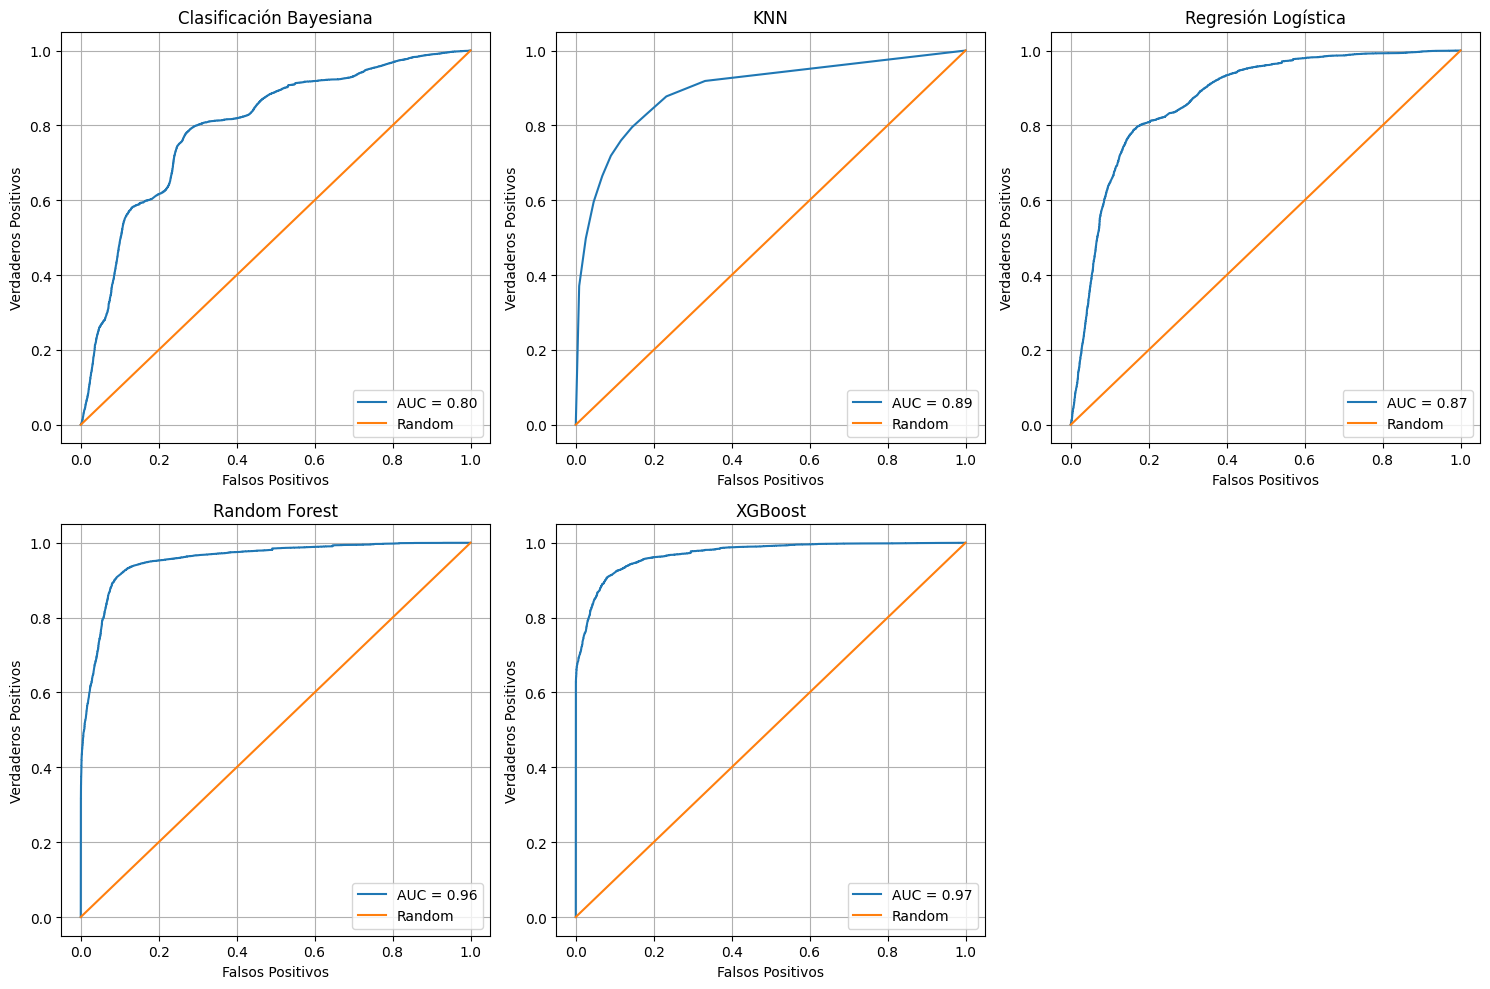

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, y_pred_proba) in enumerate(modelsProb.items()):
    fpr, tpr, thresholds = roc_curve(y_test_res, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    axes[idx].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    axes[idx].plot([0, 1], [0, 1], label="Random")
    axes[idx].set_title(name)
    axes[idx].set_xlabel("Falsos Positivos")
    axes[idx].set_ylabel("Verdaderos Positivos")
    axes[idx].legend(loc="lower right")
    axes[idx].grid()

for idx in range(len(modelsProb), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# 3. Predicciones

cargamos el dataframe de `test` que al principio se guardó formateado cuando se descartaron las columnas que tenian alta colineadidad y procederemos a predecir con este `testFormateado`

In [48]:
TestFormateado  = pd.read_csv("TestFormateado.csv")
TestFormateado.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var40_comer_ult1,imp_op_var40_efect_ult1,imp_op_var40_ult1,imp_op_var41_efect_ult1,imp_sal_var16_ult1,ind_var1_0,...,saldo_medio_var13_corto_hace3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_medio_hace3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,var38
0,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,40532.10
1,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,45486.72
2,2,23,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,46993.95
3,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,187898.61
4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,73649.73


usamos el modelo `XGBoost` con los hiperparametros `learning_rate:0.1`, `max_depth:11`, `n_estimators:200`

In [49]:
yPredichos = xgb_gridsearch.best_estimator_.predict(TestFormateado)

In [50]:
TestFormateado["TARGET"] = yPredichos

In [51]:
TestFormateado.to_csv("TestFormateadoPredicciones.csv", index=False)

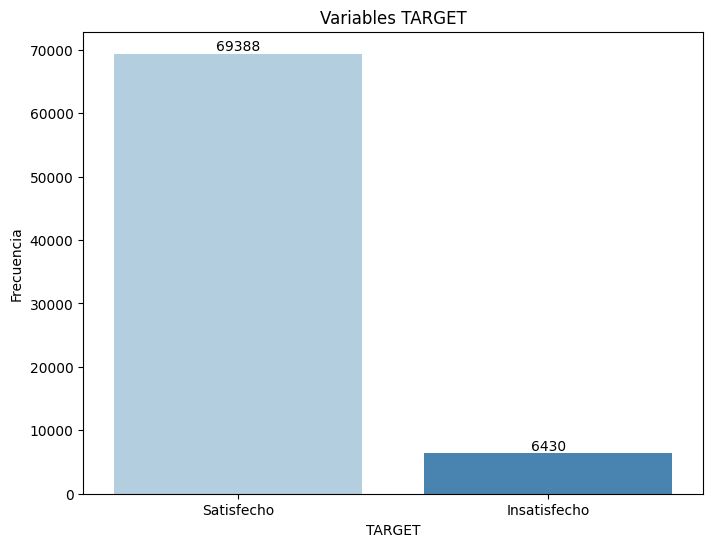

In [59]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='TARGET', data=TestFormateado, palette='Blues')
ax.set_xticklabels(estado)
plt.title("Variables TARGET")
plt.ylabel("Frecuencia")

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.show()

de los `75818` registros de clientes podemos ver que las predicciones guardan cierta proporción con los datos reales del `TARGET` de entrenamiento, predicciendo que tenemos `69388` clientes `satisfechos` y `6430` clientes `insatisfechos`